Emiliano Di Cola - emilianodicola@gmail.com

In [4]:
#Paquetes necesarios a instalar. Si lo realizamos en Colab, primero se tiene que instalar el paquete,
# y luego es posible que les solicite reiniciar el entorno. 
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#se importan las librerías
import pandas as pd
import statsmodels.tsa.stattools as tsa
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import ADFTest
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima import auto_arima
from matplotlib.pyplot import figure
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#Series temporales y algoritmos automáticos




El trabajo con series temporales muchas veces resulta poco intuitivo (por lo menos para los que no vienen de las ciencias económicas), ya que lo primero que viene a la mente ante la necesidad de generar predicciones es una base de datos con muchas variables X ordenadas temporalmente de alguna manera, que son necesarias para predecir el comportamiento de otra variable. Y, si bien esto no es incorrecto, se pierde de vista algo importante: la propia historia de la variable que se quiere predecir puede tener la fuerza suficiente como para explicar gran parte del problema.. 

Además, en general, este es el primer paso con el que hay que lidiar - y entender - antes de sumar más variables para complejizar y mejorar las predicciones, y es sobre lo que se va a trabajar en este ejemplo. 

Una Serie temporal es "el resultado de observar los valores de una variable a lo largo del tiempo, en intervalos regulares"(Daniel Peña, Análisis de series temporales) - Para los que quieran indagar más sobre el tema, Peña es un buen comienzo.

Teniendo como guía esta definición, lo que se mostrará a continuación es el proceso para predecir sobre la propia historia de una variable con diferentes algoritmos y métodos. 

La serie utilizada son los tweets diarios publicados por los usuarios geolocalizados en Río Cuarto (Córdoba, Argentina) y recolectados durante un período de tiempo de dos meses aproximadamente. 


In [6]:
url = '/content/df_arima.csv'  #link para bajar el archivo https://drive.google.com/file/d/1jjlUC29k7aDNDDhVZZVf2Pi-6N1Sz7PU/view?usp=sharing
# Se levanta la base de datos y se convierte la columna que tiene los datos temporales (ds) a DatetimeIndex, de la librería
# Pandas, que genera un objeto con los valores de tiempo.
#(más info https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html)
df_arima = pd.read_csv(url)
df_arima['ds'] = pd.DatetimeIndex(df_arima['ds'])


In [7]:
# Se convierte el objeto temporal (columna ds) en índice 
df_arima.set_index('ds', inplace = True)

In [8]:
df_arima.head()

,y
ds,
2022-07-08 00:00:00,213
2022-07-08 01:00:00,284
2022-07-08 02:00:00,425
2022-07-08 03:00:00,350
2022-07-08 04:00:00,213


#Modelos Arima - para serie univariada

Los modelos AR-I-MA (AutoRegressive Integrated Moving Average/ autoregresivos integrados de media móvil) incorporan medidas de autocorrelación (componente AR) para modelar estructuras temporales dentro de los datos y la media móvil (componente MA) de las series temporales. Ambos componentes se usan para predecir valores futuros. 

La idea detrás de estos modelos es que existe una dependencia temporal entre los datos de la serie; esto es, el dato pasado de la misma serie podría tener relación con el presente y es lo que se busca averiguar. 

La parte autoregresiva del modelo es, de algún modo, una regresión sobre la variable desde el punto cero(presente) hacia el pasado y lo que busca es encontrar dependencia con valores del pasado. El componente MA asume que el pasado inmediato permanece e influye sobre el valor del presente. Es el componente de corto plazo y suele contamplar entre uno y tres valores hacia el pasado. En resumen, un componente se extiende hacia el corto, mediano y largo plazo, mientras que el otro se enfoca en el corto.

Por los componentes y cálculos necesarios para generar el modelo, es necesario entender el comportamiento de la serie en cuanto a estacionariedad, estacionalidad y tendencia.  


Entonces, una vez cargada la base de datos, (que fue previamente limpiada y analizada), se continúa con la descomposición de la serie para comprender el comportamiento.

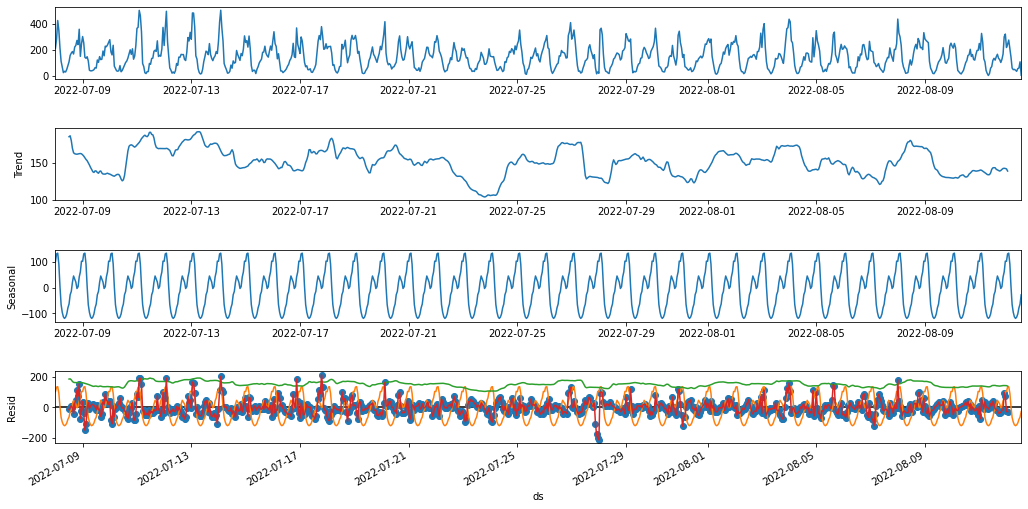

In [9]:
# Se descompone la serie seasonal_decompose, que lo que hace es dividir la serie en tres componentes:
# tendencia, estacionalidad y residuos. 
# En este caso con un modelo aditivo. También se provó con el modelo multiplicativo, mostrando 
# comportaminetos muy similires. model='multiplicative'. 
res = seasonal_decompose(df_arima, model='add');
res.plot();
# Graficos individualizados = 
res.seasonal.plot(figsize=(16,8))
res.trend.plot(figsize=(16,8))
res.resid.plot(figsize=(16,8))

# Análisis de la descomposición de la serie.

El primer gráfico es simplemente la serie.

El segundo gráfico (trend) muestra la tendencia en el largo plazo de la serie y es un indicador importante para revisar la estacionariedad.

En nuestro caso, lo que se visualiza es que la serie sube y baja alrededor de 150 (se mantiene constante alrededor de su media), por lo que es un indicador de que la serie es estacionaria. Luego hay que hacer tests para chequear que efectivamente sea así.

¿Por qué es importante la estacionariedad? Estos modelos necesitan de cierta estabilidad para alcanzar buenas predicciones. Por los componentes AR y MA, el modelo aprende de las regularidades del pasado para proyectar el futuro. Ante fenómenos muy volátiles no parecieran ser los modelos adecuados y habría que indagar por otros caminos.

En el tercer gráfico se puede observar si la serie tiene estacionalidad; o sea, si se producen comportamientos regulares en diferentes periodos de tiempo. En este caso, se visualiza una fuerte estacionalidad diaria/horas. Esto es importante porque este factor produce ruido en estos tipos de modelos.

En el cuarto gráfico, se visualizan los residuos, que es lo que se obtiene removiendo la estacionalidad y tendencia.


#Testeo de estacionariedad

Para testear la estacionariedad existen varios tests. Uno de los más utilizados es el test de Dickey-Fuller (ADF Test).
ADF es una prueba de significancia estadística por lo que involucra hipótesis nula y alternativa, se calcula el estadístico de prueba y se informa el p-value. 

El test toma como hipótesis nula que hay que diferenciar. En otras palabras, asume que no es estacionaria la serie, por lo que hay que transformarla a través de diferenciaciones (este punto se explica brevementa más adelante). En este caso, el test da un p-value menor al 0.05, por lo que no se rechaza la hipótesis alternativa, que indica que la serie es estacionaria. Además, el valor del estadístico ADF es mucho menor (o lo que es lo mismo, está corrido a la izquierda) que los valores críticos.

In [10]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))
    

In [11]:
print_test_afd(df_arima)

Estadistico ADF: -5.952484
p-valor: 0.000000
Valores criticos:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Se realizaron varios tests sobre estacionariedad porque la serie tiene una estacionalidad alta por día/hora y ese factor suele confundir los tests. Esto es una forma de asegurarse con un costo computacional mínimo.


In [12]:
def estacionario(y):
  # Estimado de número de diferencias con ADF test:Dickey-Fuller
  n_adf = ndiffs(y, test='adf')  # -> 0
  
  # KPSS test (auto_arima default): Kwiatkowski-Phillips-Schmidt-Shin
  n_kpss = ndiffs(y, test='kpss')  # -> 0
  
  # PP test: Phillips-Perron
  n_pp = ndiffs(y, test='pp')  # -> 0

  print('Estimado de número de diferencias con ADF test')
  print(n_adf)
  
  print('Estimado de número de diferencias con KPSS test')
  print(n_kpss)
  
  print('Estimado de número de diferencias con PP test')
  print(n_pp)
  
  print('Se debe realizar diferenciación (should_diff) ADF Test')
  adftest = ADFTest(alpha=0.05)
  print(adftest.should_diff(y))

In [13]:
estacionario(df_arima)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


Estos tests, que también prueban la estacionariedad, en vez de devolver el valor del estadístico muestran la cantidad de veces que una serie se tendría que diferenciar si no fuera estacionaria. Cero, como este caso, muestra que no hay que diferenciar, lo que indica que es estacionaria. 

¿Por qué habría que diferenciar?
La diferenciación consiste en restar a cada valor de la serie su valor anterior. En la práctica, esto ayuda a estabilizar la media de la serie, eliminando cambios de niveles, y sacar tendencia y estacionalidad. Cabe mencionar que hay diferentes formas de diferenciación. Puede ser la resta con un valor anterior o varios, o que no sea un valor unitario. Lo importante es que estos modelos necesitan de estacionaridad. Si la serie no es estacionaria, es necesario transformarla y luego hacer los modelos. Cada serie tiene su problema en cuanto a transformación, así como cada test tiene su particularidad para ayudar con cada problema.


Continuando con el análisis, visualizamos el comportamiento en cuanto a distribución. 

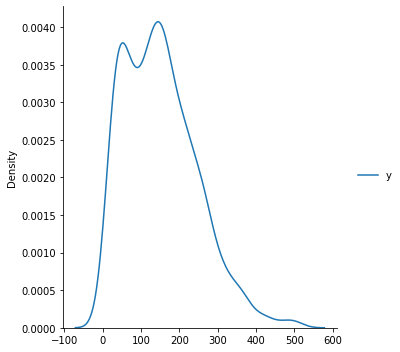

In [14]:
import seaborn as sns
sns.displot(df_arima, kind="kde")

A partir del gráfico se visualiza que no se distribuye de manera normal, por lo que se le aplicará la transformación de Box y Cox. Esta transformación estabiliza la varianza de una serie temporal y aproximar su distribución a una normal.

Esto es importante porque la falta de estacionaridad puede ser en relación a la media o en relación a su varianza. Si la serie no es estacionaria en relación con su varianza, se utilizan las transformaciones estabilizadoras de varianza como la de Box-Cox

0.44202990198163555


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


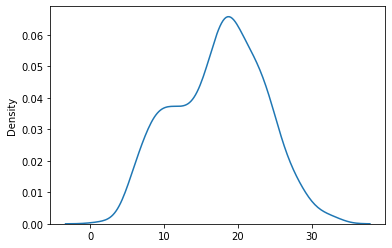

In [15]:
df_arima_boxc, best_lambda = boxcox(df_arima["y"]) 
sns.distplot(df_arima_boxc, hist=False, kde=True)
print(best_lambda) #el número lambda va a ser necesario para invertir la transformación

Hecha la transformación, se acomoda la base de datos para continuar con el proceso.

In [16]:
df_arima_boxcox =pd.DataFrame(df_arima_boxc, columns=['y'])

In [17]:
df_arima_boxcox['ds'] = df_arima.index 
df_arima_boxcox

,y,ds
0,21.934723,2022-07-08 00:00:00
1,25.215918,2022-07-08 01:00:00
2,30.575570,2022-07-08 02:00:00
3,27.874882,2022-07-08 03:00:00
4,21.934723,2022-07-08 04:00:00
...,...,...
849,8.628831,2022-08-12 09:00:00
850,11.143726,2022-08-12 10:00:00
851,11.558866,2022-08-12 11:00:00
852,15.659544,2022-08-12 12:00:00


In [18]:
df_arima_boxcox.ds = pd.to_datetime(df_arima_boxcox.ds) 
df_arima_boxcox.set_index("ds", inplace=True)

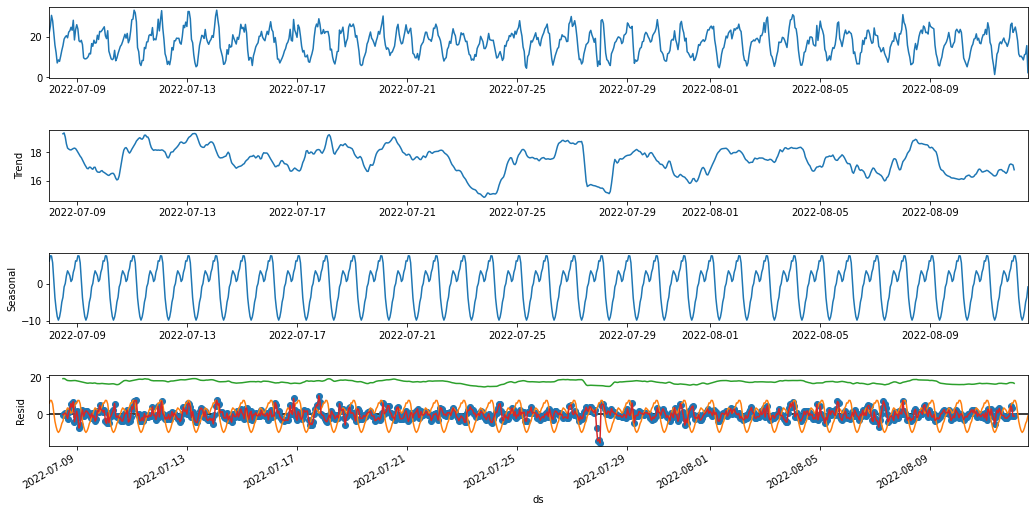

In [19]:
#Se descompone la serie y se visualizan los datos nuevamente.
res = seasonal_decompose(df_arima_boxcox, model='add');
res.plot();
# Gráficos individualizados = 
res.seasonal.plot(figsize=(16,8))
res.trend.plot(figsize=(16,8))
res.resid.plot(figsize=(16,8))

In [20]:
#Nuevamente se revisa la estacionariedad
estacionario(df_arima_boxcox)

Estimado de número de diferencias con ADF test
0
Estimado de número de diferencias con KPSS test
0
Estimado de número de diferencias con PP test
0
Se debe realizar diferenciación (should_diff) ADF Test
(0.01, False)


In [21]:
print_test_afd(df_arima_boxcox)

Estadistico ADF: -6.024177
p-valor: 0.000000
Valores criticos:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [22]:
#En particular, como la serie es estacionaria no es necesario diferenciarla. Por lo que 
#no fue necesario aplicar el siguiente código. 
#df_ = df_arima_boxcox.diff(axis = 0, periods = 3)


Continuando con los análisis, para los modelos Arima y modelos que son autoregresivos, el siguiente paso es visualizar la correlación de la serie (autocorrelación) a través de dos funciones: Función de autocorrelación (acf) y función de autocorrelación parcial(pacf)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


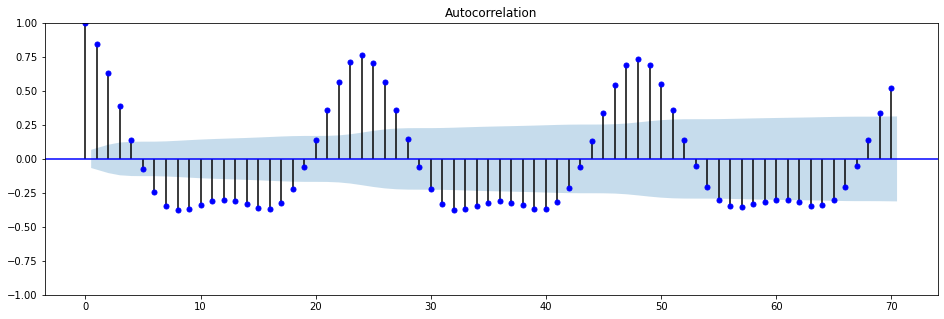

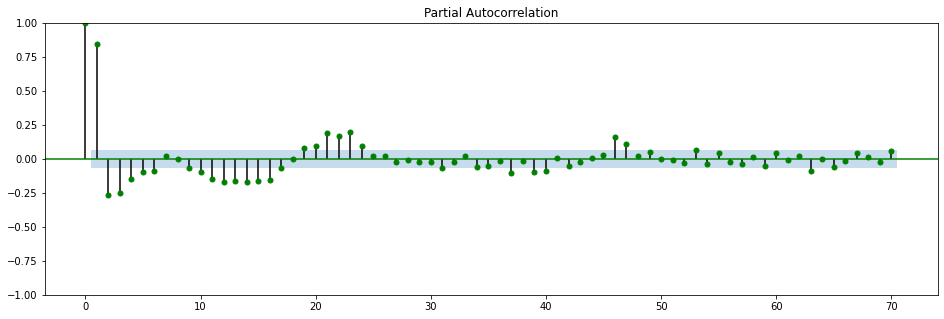

In [23]:
acf_plot = plot_acf(df_arima_boxcox, lags=70, color= 'blue')
pacf_plot = plot_pacf(df_arima_boxcox, lags=70, color= 'green')

pacf_plot.set_size_inches(16,5)
acf_plot.set_size_inches(16,5)

El primer gráfico, la acf (Función de autocorrelación) sirve para continuar corroborando si la serie es estacionaria. La forma de verlo es por la pendiente del gráfico. Cuando la caída es exponencial, significa estacionaridad.  Por otro lado, da señales de cuántos componentes MA del ARIMA son necesarios para hacer una predicción. En este sentido, pareciera que entre uno y tres lags son influyentes para armar el modelo de predicción. 

En cuanto al segundo gráfico, el pacf (Función de autocorrelación parcial) permite detectar cuáles son los lags significativos (o importantes) para el componente AR para poder armar el modelo predictivo. En principio, desde el gráfico se puede visualizar que los lags del uno al cuatro son muy importantes y en general, desde el lag uno al 24. Para detectar con cuántos lags nos quedamos en el modelo final, en general se prueban diferentes números hasta encontrar la mejor predicción.

Hay dos formas para hacer las pruebas y encontrar el mejor modelo: la manual y la automática. En este caso se utilizó la manera automática. No siempre es lo mejor.

Se utilizó el algoritmo Auto Arima, que está desarrollado para buscar el mejor modelo ARIMA. 

A continuación el código para correr los modelos.

In [24]:
#Se separan en train y test para entrenar el modelo y se corre el algoritmo
train = df_arima_boxcox[:int(0.7*(len(df_arima_boxcox)))]
test = df_arima_boxcox[int(0.7*(len(df_arima_boxcox))):]

#Seasonal=True como se señaló, la serie es estacional. Por lo que es parámetro 
#Seasonal le dice al algoritmo que hay estacionalidad. En la práctica, lo convierte en un modelo SARIMA

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True) 
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2984.095, Time=1.36 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3843.913, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3102.269, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3394.276, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5181.427, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3046.287, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2982.684, Time=0.93 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3071.556, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3052.600, Time=0.51 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2983.981, Time=3.43 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3018.489, Time=0.75 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2986.169, Time=2.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3123.827, Time=0.35 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 11.059 seconds


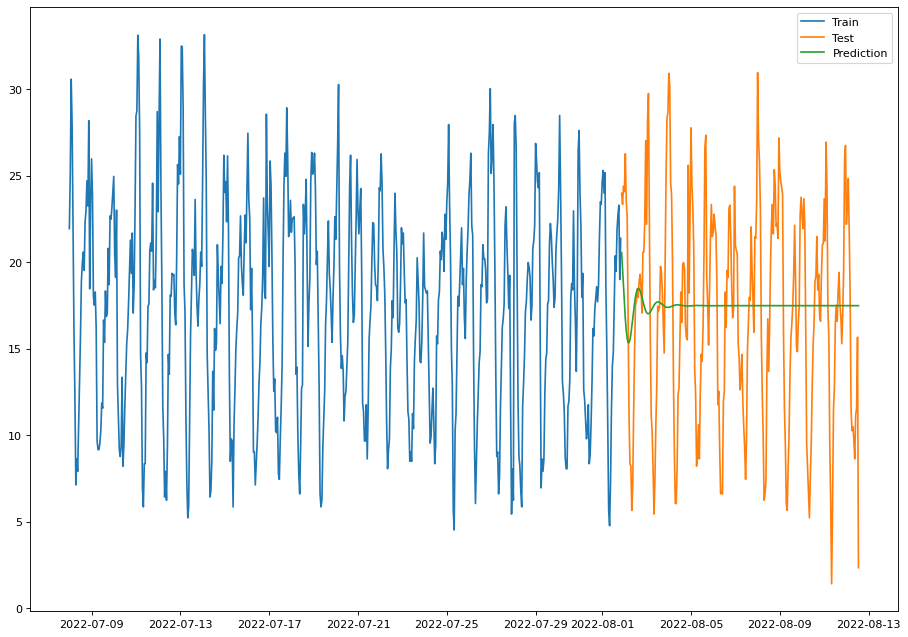

In [25]:
figure(figsize=(14, 10), dpi=80)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

El resultado del primer modelo es muy pobre en cuanto a predicción. Para mejorarlo, vamos a agregar el parámetro de estacionalidad (m), por el cual se le indica al algoritmo el tipo de estacionalidad para ayudarlo a mejorar la predicción y que solo encuentre el resto de los parámetros. 

Para interpretar el modelo, hay que observar varias cosas. La primera son los números que se encuentran en la misma línea donde dice ARIMA. Allí se ve que hay 6 números dividos en dos por paréntesis. 

Los primeros tres son los lags que prueba el modelo en cuanto a los componentes AR, MA y si fuese necesario diferenciar. Por ejemplo, la primera línea, tiene en cuenta dos lags para el componente AR(2) y dos lags para el componente MA(2). El valor del medio indica si se diferencia la serie. Estos componentes son los que también se encuentran en la literatura como p,d,q o AR(p), d y MA(q).

¿Qué significa agregarle a un modelo Arima la estacionalidad?

En la práctica, estos modelos suelen llamarse SARIMA y la s es por seasonality. Lo que incorpora es la idea de que la serie tiene ciclos que se repiten y que, de acuerdo con esa repetición, se condicionan los valores AR y MA y los componentes estacionales. 

En el próximo modelo se agrega este componente para ver si se mejora el resultado.

In [26]:
#m = 18
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=18) 
model.fit(train)

forecast = model.predict(n_periods=len(test)) 
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[18] intercept   : AIC=2946.482, Time=7.96 sec
 ARIMA(0,0,0)(0,0,0)[18] intercept   : AIC=3843.913, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[18] intercept   : AIC=3082.329, Time=2.25 sec
 ARIMA(0,0,1)(0,0,1)[18] intercept   : AIC=3354.048, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[18]             : AIC=5181.427, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[18] intercept   : AIC=2980.173, Time=5.83 sec
 ARIMA(2,0,2)(1,0,0)[18] intercept   : AIC=2979.523, Time=5.53 sec
 ARIMA(2,0,2)(2,0,1)[18] intercept   : AIC=2939.538, Time=25.46 sec
 ARIMA(2,0,2)(2,0,0)[18] intercept   : AIC=2987.439, Time=24.51 sec
 ARIMA(2,0,2)(2,0,2)[18] intercept   : AIC=inf, Time=25.19 sec
 ARIMA(2,0,2)(1,0,2)[18] intercept   : AIC=inf, Time=21.47 sec
 ARIMA(1,0,2)(2,0,1)[18] intercept   : AIC=3044.445, Time=12.40 sec
 ARIMA(2,0,1)(2,0,1)[18] intercept   : AIC=inf, Time=21.28 sec
 ARIMA(3,0,2)(2,0,1)[18] intercept   : AIC=inf, Time=22.34 sec
 ARIMA(2,0,3)(2,0,1)[18] interce

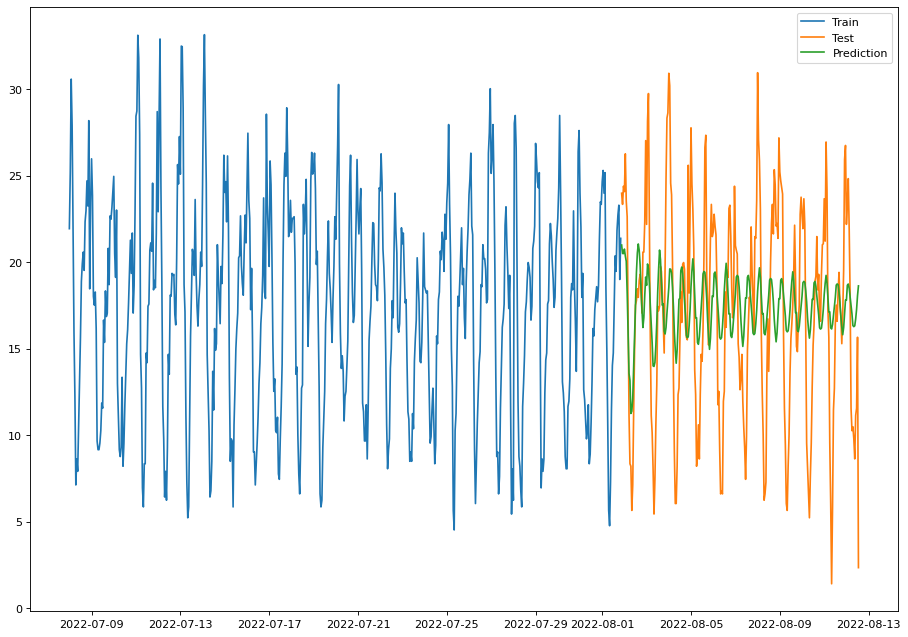

In [27]:
figure(figsize=(14, 10), dpi=80)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [28]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  597
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 18)   Log Likelihood               -1460.769
Date:                              Mon, 26 Sep 2022   AIC                           2939.538
Time:                                      17:21:10   BIC                           2979.065
Sample:                                  07-08-2022   HQIC                          2954.929
                                       - 08-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0376      0.297      6.861      0.000       1.456       2.620
ar.L1          1.84

In [29]:
# Se calculan medidas de precisión
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test, forecast)
print('Test MAE: %.3f' % mae)
r2 = r2_score(test, forecast)
print('Test R2: %.3f' % r2)

Test RMSE: 5.408
Test MSE: 29.242
Test MAE: 4.433
Test R2: 0.227


In [30]:
#para poder comparar con otros modelos que no requieren de tranformación BoxCox, 
#se revirte la transformación
test_inversa_boxc = inv_boxcox(test, 0.4420 )
forecast_inversa_boxc = inv_boxcox(forecast, 0.4420)

In [31]:
# Se calculan medidas de precisión.
# Las medidas acá calculadas son las que nos van a permitir comparar la precisión de las predicciones
rmse = sqrt(mean_squared_error(test_inversa_boxc, forecast_inversa_boxc))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test_inversa_boxc, forecast_inversa_boxc)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test_inversa_boxc, forecast_inversa_boxc)
print('Test MAE: %.3f' % mae)
r2 = r2_score(test_inversa_boxc, forecast_inversa_boxc)
print('Test R2: %.3f' % r2)

Test RMSE: 83.720
Test MSE: 7009.048
Test MAE: 66.362
Test R2: 0.189


In [32]:
resultado = pd.concat ([test_inversa_boxc, forecast_inversa_boxc], axis=1)
resultado["dif"] = resultado["y"] - resultado["Prediction"] 
resultado.tail(n=30)

,y,Prediction,dif
ds,,,
2022-08-11 08:00:00,3.000046,114.671408,-111.671362
2022-08-11 09:00:00,18.001533,118.457603,-100.456070
2022-08-11 10:00:00,59.008735,126.363086,-67.354351
2022-08-11 11:00:00,72.011477,133.803661,-61.792185
2022-08-11 12:00:00,119.022466,142.027763,-23.005297
2022-08-11 13:00:00,135.026503,153.515786,-18.489282
2022-08-11 14:00:00,121.022964,154.685107,-33.662143
2022-08-11 15:00:00,147.029611,153.834785,-6.805174
2022-08-11 16:00:00,166.034658,147.015551,19.019106


En el modelo, agregando la estacionalidad, mejora mucho la predicción. En línes generales, predice mal los extremos pero bastante acertado en los medios. Esto sucede porque los modelos Arima están pensados para problemas que no tienen tanta volatilidad sino para modelos más estables.

Al parámetro m hay que indicarle el ciclo. La serie con la que se está trabajando tiene una estacionalidad diaria/por hora, por lo que un m=24 sería un número razonable. Si fuese anual, debería ser m=1. No obstante, siempre hay que probar y revisar los resultados.

Se realizaron dos pruebas: con m = 18 y 24. El modelo con m = 18 toma un AR(2) y un MA(2) con ninguna diferenciación. Los tres números siguientes en la primera corrida estaban en cero y desde que se agregó la estacionalidad, el algoritmo comenzó a cambiar números y probar el mejor parámetro. Esos parámentros, son los AR y MA en el ciclo m=18 que se le pasó al algoritmo.



In [33]:
#m24
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=24,scoring = "mae") #Seasonal=True hace al modelo SARIMA
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=8.54 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3843.913, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2995.316, Time=2.21 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=3241.395, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5181.427, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=3102.269, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=2959.896, Time=12.46 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=19.86 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.65 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=22.28 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=2958.814, Time=11.39 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=2987.288, Time=2.80 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=24.54 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.63 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept   : AIC=2

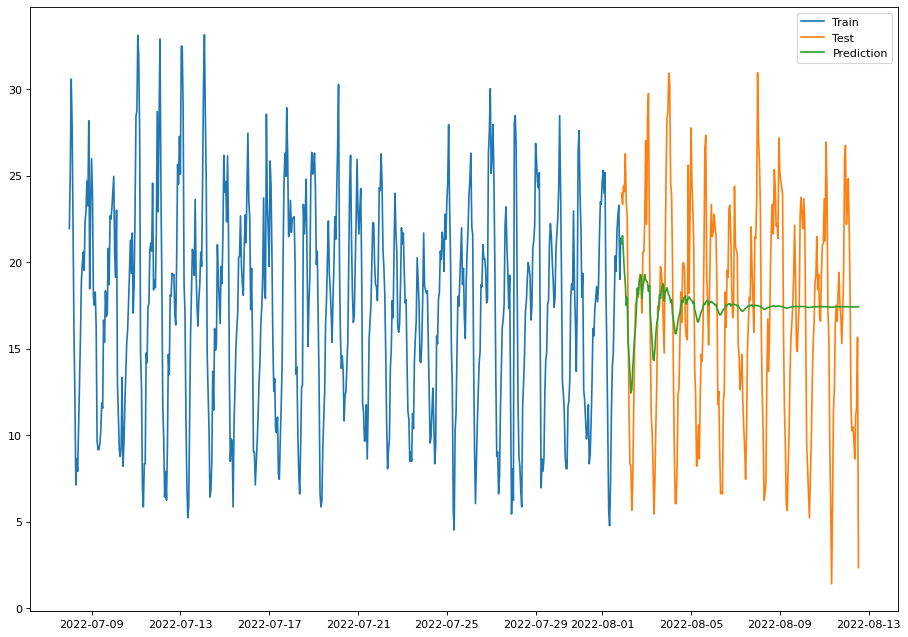

In [34]:
figure(figsize=(14, 10), dpi=80)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [35]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  597
Model:             SARIMAX(3, 0, 1)x(2, 0, [], 24)   Log Likelihood               -1462.897
Date:                             Mon, 26 Sep 2022   AIC                           2941.793
Time:                                     17:28:51   BIC                           2976.929
Sample:                                 07-08-2022   HQIC                          2955.474
                                      - 08-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1071      0.262      4.220      0.000       0.593       1.621
ar.L1          1.6083      

In [36]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=18,D=1,
                   max_p = 3, max_q = 3) #Seasonal=True hace al modelo SARIMA
model.fit(train)

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[18] intercept   : AIC=inf, Time=15.64 sec
 ARIMA(0,0,0)(0,1,0)[18] intercept   : AIC=4237.727, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[18] intercept   : AIC=3261.718, Time=1.87 sec
 ARIMA(0,0,1)(0,1,1)[18] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(0,0,0)(0,1,0)[18]             : AIC=4235.741, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[18] intercept   : AIC=3513.363, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[18] intercept   : AIC=3236.855, Time=6.98 sec
 ARIMA(1,0,0)(2,1,1)[18] intercept   : AIC=inf, Time=22.09 sec
 ARIMA(1,0,0)(1,1,1)[18] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(0,0,0)(2,1,0)[18] intercept   : AIC=4033.928, Time=8.39 sec
 ARIMA(2,0,0)(2,1,0)[18] intercept   : AIC=3185.427, Time=5.60 sec
 ARIMA(2,0,0)(1,1,0)[18] intercept   : AIC=3213.129, Time=2.33 sec
 ARIMA(2,0,0)(2,1,1)[18] intercept   : AIC=inf, Time=19.23 sec
 ARIMA(2,0,0)(1,1,1)[18] intercept   : AIC=inf, Time=8.32 sec
 ARIMA(3,0,0)(2,1,0)[18] intercept   : AIC=314

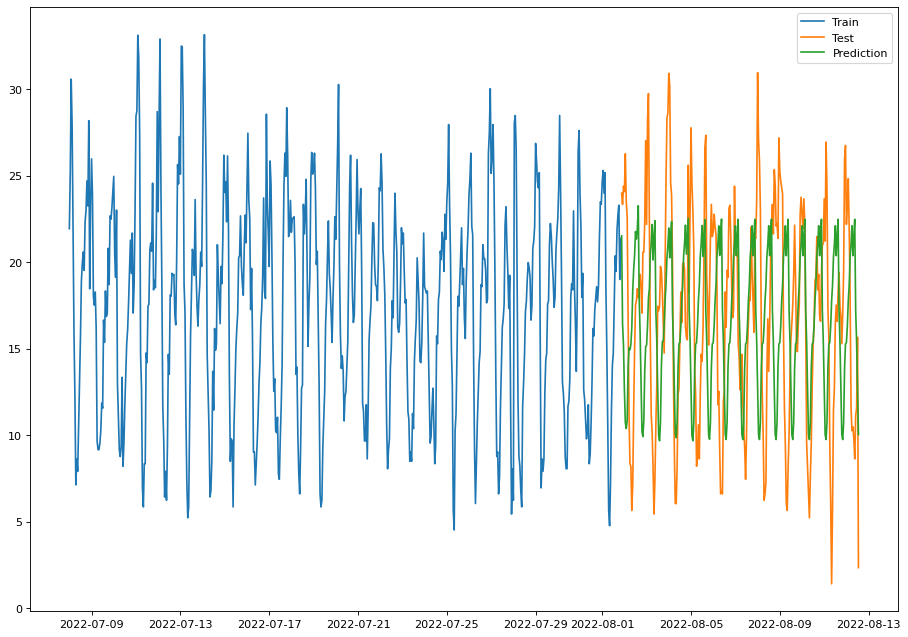

In [37]:
figure(figsize=(14, 10), dpi=80)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [38]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  597
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 18)   Log Likelihood               -1540.415
Date:                             Mon, 26 Sep 2022   AIC                           3092.829
Time:                                     17:36:33   BIC                           3118.997
Sample:                                 07-08-2022   HQIC                          3103.032
                                      - 08-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8249      0.021     88.755      0.000       1.785       1.865
ar.L2         -0.8990      

In [39]:
# Cálculo de las medidas de precisión
rmse = sqrt(mean_squared_error(test, forecast))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(test, forecast)
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(test, forecast)
print('Test MAE: %.3f' % mae)
r2 = r2_score(test, forecast)
print('Test R2: %.3f' % r2)

Test RMSE: 7.542
Test MSE: 56.875
Test MAE: 6.201
Test R2: -0.504


Hasta acá lo que se ha hecho es trabajar con un modelo Arima. Como conlusión, se podría decir que ante series volátiles los modelos Arima no son los óptimos

Debido a que todavía no se logró una buena predicción, se probará con Prophit y Pycaret. El primero, es un algoritmo creado por Facebook y que trabaja mucho mejor la volatilidad. El segundo, Pycaret es Auto ML, que nos indicará de muchos algoritmos, cuál es el más indicado para la serie.

Por último, para aquellos que estén interesados en el tema, la predicción realizada en este Colab puede ser mejorable. Aquellos que deseen enviar sus mejoras o consultas pueden enviarlas vía mail.  

Link a los siguientes Colabs:

Prophet Colab 2/3
https://drive.google.com/file/d/1cKr1_Y9687PjGWVT0o4ptMpByCSW81A7/view?usp=sharing


Pycaret Colab 3/3
https://drive.google.com/file/d/1guqEqPDYt1AIOD7DODaJRYNBnze7nC10/view?usp=sharing